## Load packages

In [2]:
import warnings

from openpyxl.styles.builtins import title

warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import torch

import STAHD
os.environ['R_HOME'] = "/usr/lib/R/"
os.environ['R_USER'] = "~/.conda/envs/STAHD/lib/python3.8/site-packages/rpy2"
            
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Load Data

In [3]:
section_id = '151673'
input_dir = os.path.join('/home/dwang/', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique(join="++")

# read the annotation
Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
Ann_df[Ann_df.isna()] = "unknown"
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

# make spot name unique
adata.obs_names = [x + '_' + section_id for x in adata.obs_names]

# Constructing the spatial network
STAHD.Cal_Spatial_Net(adata, rad_cutoff=275)  # the spatial network are saved in adata.uns[‘adj’]
# STAHD.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
adata.uns['edgeList'] = np.nonzero(adata.uns['adj'])

# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]

------Calculating spatial graph...
The graph contains 41834 edges, 3639 cells.
11.4960 neighbors per cell on average.


## Running STAHD and Clustering

In [6]:
strna = STAHD.train_STAHD(adata, hidden_dims=[50, 30], verbose=True, n_epochs=200, device=used_device,random_seed=1023)
STAHD.mclust_R(strna, num_cluster=7, used_obsm='STAHD')

from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(strna[strna.obs['Ground Truth'] != 'unknown'].obs['Ground Truth'],
                                         strna[strna.obs['Ground Truth'] != 'unknown'].obs['mclust']))

STAHD(
  (conv1): GATConv(5000, 50, heads=1)
  (conv2): GATConv(50, 30, heads=1)
  (conv3): GATConv(30, 50, heads=1)
  (conv4): GATConv(50, 5000, heads=1)
)
Pretrain with STAHD...


100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


fitting ...

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%


mclust, ARI = 0.617


## Visualization

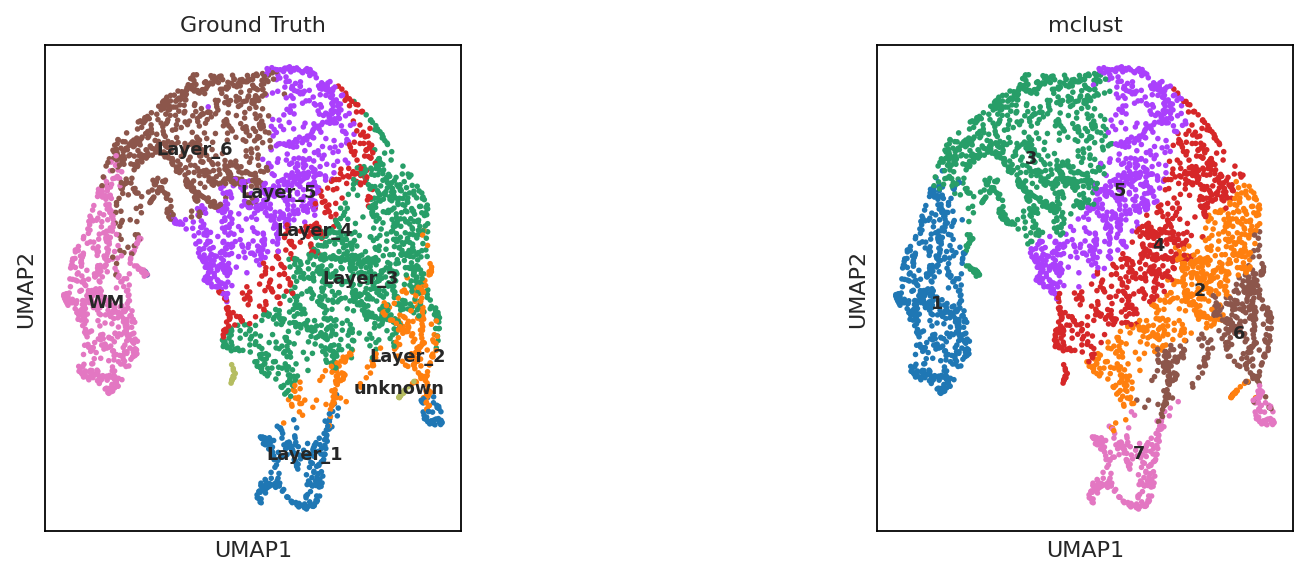

In [10]:
sc.pp.neighbors(strna, use_rep="STAHD", metric="cosine")
sc.tl.umap(strna)
sc.settings.set_figure_params(frameon=True, fontsize=10, facecolor='white',figsize=(4, 4)) #dpi=300,

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 8
spot_size = 5
title_size = 15
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 1.0, 'hspace': 0.1})

# sc.pl.umap(strna, color=["mclust"], wspace=1, show=False, ax=ax[0], size=25)
sc.pl.umap(strna, color=["Ground Truth"], wspace=1, show=False, ax=ax[0], legend_loc='on data', size=25)
sc.pl.umap(strna, color=["mclust"], wspace=1, show=False, ax=ax[1], legend_loc='on data', size=25)
plt.show()

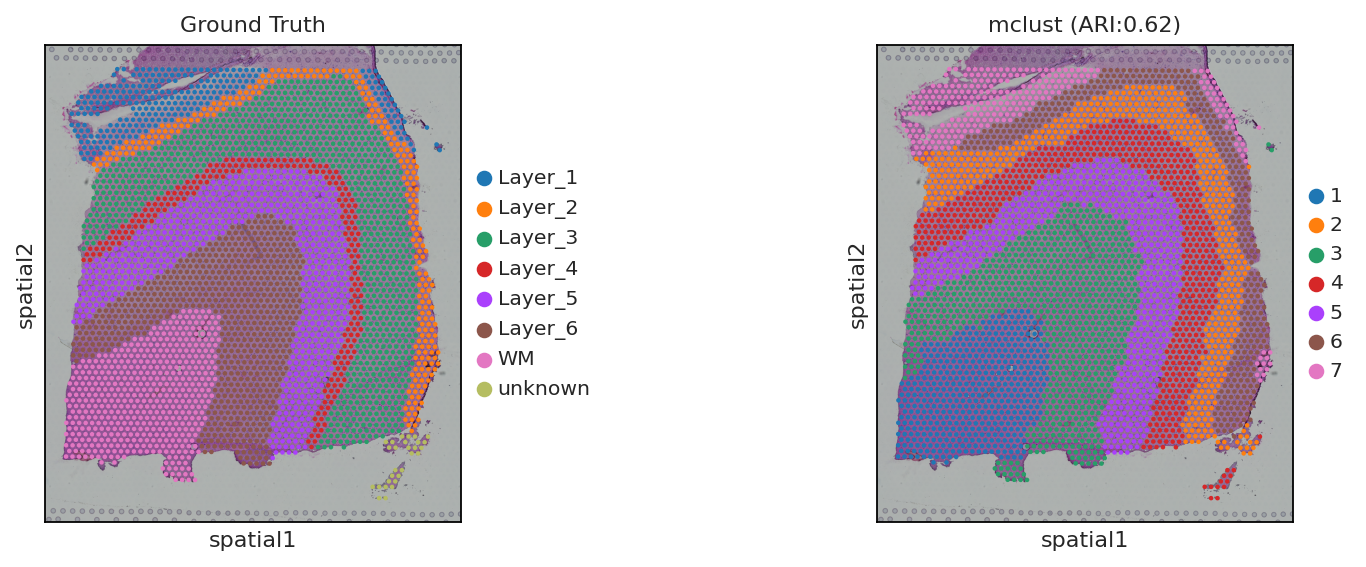

In [27]:
from sklearn.metrics import adjusted_rand_score as ari_score
ari=ari_score(strna[strna.obs['Ground Truth'] != 'unknown'].obs['Ground Truth'],
                                         strna[strna.obs['Ground Truth'] != 'unknown'].obs['mclust'])

fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 1.0, 'hspace': 0.1})

# sc.pl.umap(strna, color=["mclust"], wspace=1, show=False, ax=ax[0], size=25)
sc.pl.spatial(strna, color=["Ground Truth"], wspace=1, show=False, ax=ax[0],  size=1)
sc.pl.spatial(strna, color=["mclust"],title=f"mclust (ARI:{ari:.2f})", wspace=1, show=False, ax=ax[1],  size=1)
plt.show()
